In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv('Data/test_st.csv')

In [61]:
df['value_created_at'] = pd.to_datetime(df['value_created_at'])

In [86]:
list_sensors = ['NGA']
list_metrics = ['Median', 'STD', 'PPV','rms','ppv','cf','mf','sf','if']
window_size = 50
num_window = int(len(df)//window_size)
cut_factor = 0.2

In [87]:
def calc_metric_stats(serie, metric):
    if metric == 'STD':
        return np.std(serie)
    elif metric == 'PPV':
        return np.max(serie) - np.min(serie)
    elif metric == 'Median':
        return np.median(serie)
    elif metric == 'z_score' :
        mean_value = serie.mean()
        std_value = serie.std()
        return (serie - mean_value) / std_value
    elif metric == 'rms':
        return np.sqrt(np.mean(np.square(serie)))
    elif metric == 'ppv':
        ppv = np.max(serie) - np.min(serie)
        return ppv
    elif metric == 'cf':
        max_value = np.max(np.abs(serie))
        sum_values = np.sum(np.square(serie))
        return max_value / np.sqrt(sum_values)
    elif metric == 'mf':
        mu = np.mean(serie)
        max_value = np.max(serie)
        min_value = np.min(serie)
        return (max_value - min_value) / mu
    elif metric == 'sf':
        mu = np.mean(serie)
        sigma = np.std(serie)
        return sigma / mu
    elif metric == 'if':
        max_value = np.max(np.abs(serie))
        sum_values = np.sum(np.abs(serie))
        return max_value / sum_values


In [88]:
def Algorithm2(F, J, K, cut_factor, data_full):
    list_idx_cut = list()
    cut = int(np.round(cut_factor * K))
    if(cut > 0):
        D = F*J
        lpoints = list()
        for k in range(K):
            point = np.zeros(D)
            d = 0
            for i in range(F):
                for j in range(J):
                    point[d] = data_full[k][i][j]
                    d += 1
            lpoints.append(point)
            
        maxpoint = np.full(D, -np.inf)
        minpoint = np.full(D, np.inf)

        for k in range(K):
            for d in range(D):
                maxpoint[d] = max(lpoints[k][d], maxpoint[d])
                minpoint[d] = min(lpoints[k][d], minpoint[d])

        lpoints_normalized = list()
        for k in range(K):
            point = np.zeros(D)
            for d in range(D):
                point[d] = (lpoints[k][d] - minpoint[d])/(maxpoint[d] - minpoint[d])
            lpoints_normalized.append(point)

        centroid = np.zeros(D)
        for k in range(K):
            for d in range(D):
                centroid[d] += lpoints_normalized[k][d]/K

        list_dist_centroid = list()
        for k in range(K):
            list_dist_centroid.append(np.linalg.norm(lpoints_normalized[k]-centroid))

        order = np.argsort(list_dist_centroid)
        for c in range(cut):
            list_idx_cut.append(order[len(order)-c-1])
    return list_idx_cut

In [89]:
def create_dataframe(data_to_df, list_sensors, list_metrics):
    pass

In [90]:
F = len(list_sensors)
J = len(list_metrics)
K = num_window
N = window_size
data_full = np.zeros((K,F,J))

In [91]:
for k in range(K):
    for i in range(F):
        data_sensor = df[list_sensors[i]].values
        serie = data_sensor[k*N:(k+1)*N]
        for j in range(J):
            # print(list_metrics[j])
            data_full[k][i][j] = calc_metric_stats(serie, list_metrics[j])
            #print(data_full)

In [92]:
data_full.shape

(114, 1, 9)

In [93]:
list_idx_cut = Algorithm2(F, J, K, cut_factor, data_full)

In [94]:
list_idx_cut

[63,
 109,
 62,
 57,
 45,
 42,
 43,
 113,
 46,
 111,
 0,
 112,
 110,
 61,
 80,
 60,
 44,
 99,
 59,
 96,
 78,
 64,
 83]

In [95]:
count = 0
for value in df.iloc[3000:4000].NGA.values:
    if value < .1 :
        count +=1 

count

14

<Axes: >

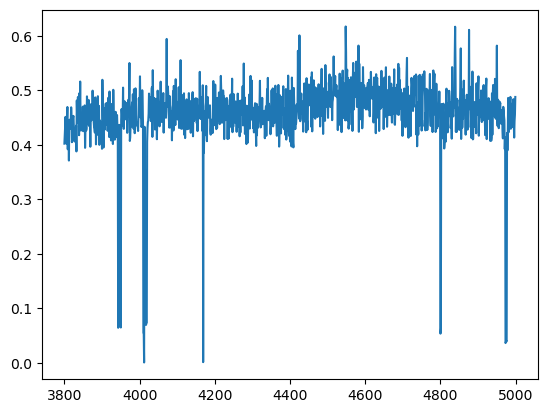

In [96]:
df[3800:5000].NGA.plot()

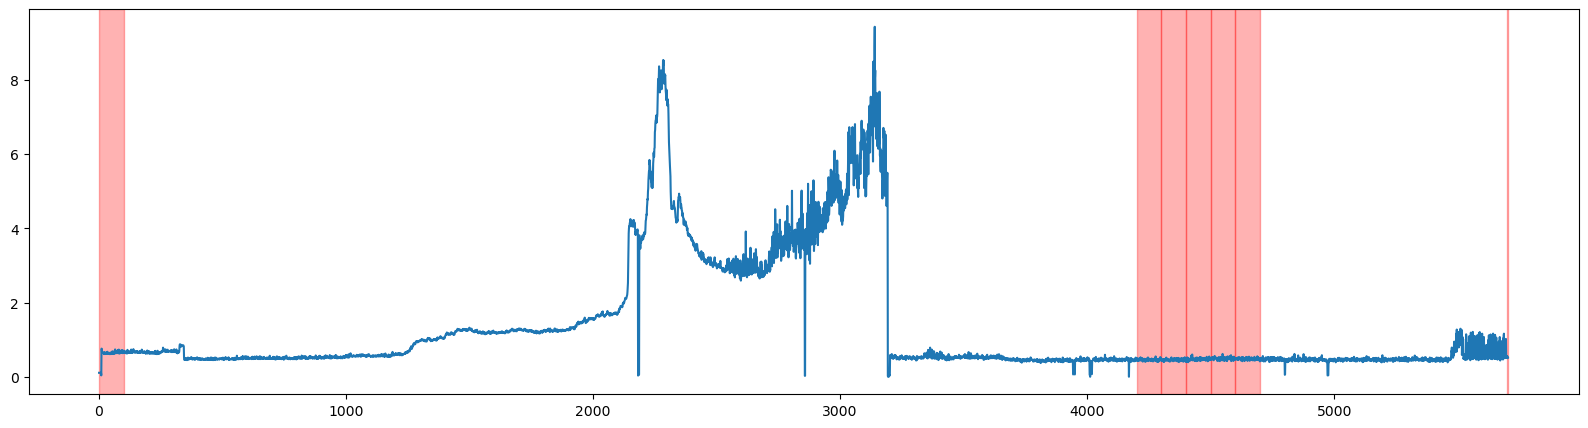

In [97]:
data_length = len(df.NGA.values)
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(df.NGA.values)
for idx in list_idx_cut:
    start = idx * 100
    end = (idx + 1) * 100
    if start < data_length:
        end = min(end, data_length)  
        ax.axvspan(start, end, color='red', alpha=0.3)

In [16]:
data_range = list()
for i in range(F):
    lmtr_min = list()
    lmtr_max = list()
    for j in range(J):
        list_metric_per_window = list()
        for k in range(K):
            if(k not in list_idx_cut):
                list_metric_per_window.append(data_full[k][i][j])
        lmtr_min.append(np.min(list_metric_per_window))
        lmtr_max.append(np.max(list_metric_per_window))
    data_range.append((lmtr_min, lmtr_max))

In [26]:
print(len(data_range))
print(data_range)

2
[([0.442005, 0.015903493949129544, 0.07001000000000002], [4.684255, 0.5368924554034634, 2.54419]), ([4.230075, 0.09460562439284462, 0.5011400000000004], [12.867515000000001, 1.4965098452804477, 5.52203])]


In [27]:
data_to_df = list()
for j in range(J):
    list_min_values_per_sensor = list()
    for i in range(F):
        list_min_values_per_sensor.append(data_range[i][0][j])
    data_to_df.append(list_min_values_per_sensor)
    list_max_values_per_sensor = list()
    for i in range(F):
        list_max_values_per_sensor.append(data_range[i][1][j])
    data_to_df.append(list_max_values_per_sensor)
df_model = create_dataframe(data_to_df, list_sensors, list_metrics)

In [ ]:
def test(list_sensors, list_metrics, current_window, df_model):
    F = len(list_sensors)
    J = len(list_metrics)
    report = dict()
    sum_error_rel = 0
    for name_sensor in list_sensors:
        list_sensors_affecteds = list()
        serie = current_window[name_sensor].values
        for j in range(J):
            metric = calc_metric_stats(serie, list_metrics[j])
            v_min =  df_model.loc[name_sensor].loc[list_metrics[j]['min']
            v_max =  df_model.loc[name_sensor].loc[list_metrics[j]['max']
            if metric < v_min:
                error_rel_normalized = np.abs((metric-v_min)/(v_max-v_min))
                sum_error_rel += error_rel_normalized
                #list_sensors_affecteds.append()
                report['count_metrics'] = 
            if metric < v_min:
                error_rel_normalized = np.abs((metric-v_min)/(v_max-v_min)-1)
                sum_error_rel += error_rel_normalized
                #list_sensors_affecteds.append()
    if report.c